In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython
import os
import tensorflow as tf
import librosa
import cv2

In [2]:
AUDIO_LENGTH = 4
LOG_EPS = 1e-6

## size 256x256 22050 Hz
# SAMPLING_RATE = 22050
# FRAME_STEP = 345
# FRAME_SIZE = 512

## size 256x256 44100 Hz
# SAMPLING_RATE = 44100
# FRAME_STEP = 1024
# FRAME_SIZE = 512
# SIZE = NUM_MEL = 256

## size 512x512 44100 Hz
SAMPLING_RATE = 44100
FRAME_SIZE = 1024
SIZE = NUM_MEL = 512
FRAME_STEP = 345

RGB_IMG = False

CLIP_NSTD = 3.
SLICE_LEN = SAMPLING_RATE * AUDIO_LENGTH

In [3]:
mel_filter_bank = tf.signal.linear_to_mel_weight_matrix(
                            num_mel_bins=NUM_MEL,
                            num_spectrogram_bins=NUM_MEL,
                            sample_rate=SAMPLING_RATE,
                            lower_edge_hertz=0,
                            upper_edge_hertz=SAMPLING_RATE/2.0)

# Get the inverse mel transformation matrix.
def mel_to_linear_matrix(m):
    m_t = np.transpose(m)
    p = np.matmul(m, m_t)
    d = [1.0 / x if np.abs(x) > 1.0e-8 else x for x in np.sum(p, axis=0)]
    return np.matmul(m_t, np.diag(d))

mel2lin = mel_to_linear_matrix(mel_filter_bank)

In [4]:
def RGB_to_spec(img, mn, mx):
    img = img.astype('float32')
    rec_spec = img / 255.0
    rec_spec = rec_spec * (mx - mn)
    rec_spec += mn
    return rec_spec

In [5]:
suffix = str(SIZE)

stat_dir = "..\\datasets\\UrbanSound8K\\stat"

def get_combined_mean_std(spec_type):

    batch_n = 3

    all_mean = np.empty(shape=(3, 512))
    all_std = np.empty(shape=(3, 512))

    for i in range(batch_n):
        
        with open(os.path.join(stat_dir, 'mean_' + spec_type + f'_{suffix}_batch{i}.npy', 'rb')) as f:
            mean_mel = np.load(f)
        with open(os.path.join(stat_dir, 'std_' + spec_type + f'_{suffix}_batch{i}.npy', 'rb')) as f:
            std_mel = np.load(f)

        all_mean[i] = mean_mel.copy()
        all_std[i] = std_mel.copy()

    print(all_mean.shape)

    n1 = 1024000
    n2 = 886784
    n = n1*2 + n2

    mean_combined = (all_mean[0] * n1 + all_mean[1] * n1 + all_mean[2] * n2) / n

    d1 = (all_mean[0] - mean_combined)**2
    d2 = (all_mean[1] - mean_combined)**2
    d3 = (all_mean[2] - mean_combined)**2
    std_combined = np.sqrt((n1*(all_std[0]**2) + n1*(all_std[1]**2) + n2*(all_std[2]**2) + n1*d1 + n1*d2 + n2*d3) / (n1*2 + n2))

    return mean_combined, std_combined


def get_mean_std(spec_type):
    if spec_type == 'spec': spec_type = 'mel'
    mean = np.load(os.path.join(stat_dir, 'mean_' + spec_type + f'_{suffix}.npy'))
    std = np.load(os.path.join(stat_dir, 'std_' + spec_type + f'_{suffix}.npy'))
    return mean, std

In [6]:
C = 0

# load dataset mean and std
stft_mean, stft_std = get_mean_std('stft')
mel_mean, mel_std = get_mean_std('mel')

# invert spectrogram
def specgram_to_audio(img, spec_type='stft', niter=44, min_max_path=None):
    if spec_type == 'stft':
        audio = stft_to_audio(img, stft_mean, stft_std, niter)
    else:
        audio = stft_to_audio(img, mel_mean, mel_std, niter)
    return audio.numpy()

# Griffin-Lim phase estimation from magnitude spectrum
def invert_spectra_griffin_lim(X_mag, nfft, nhop, ngl, spec_type): 
    X = tf.complex(X_mag, tf.zeros_like(X_mag))

    def loop_body(i, X_best):
        x = tf.signal.inverse_stft(X_best, nfft, nhop)
        X_est = tf.signal.stft(x, frame_length = nfft, frame_step = nhop)
        tf_type = X_est.dtype
        phase = X_est / tf.cast(tf.maximum(1e-8, tf.abs(X_est)), tf_type)
        X_best = X * phase
        return i + 1, X_best
    
    i = tf.constant(0)
    cond = lambda i, _: tf.less(i, ngl) # i < ngl
    _, X = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(cond, loop_body, [i, X]))
    x = tf.signal.inverse_stft(X, nfft, nhop)
    x = x[:SLICE_LEN]
    return x

def stft_to_audio(img, mean, std, niter=44):
    X_norm = img[:,:,C]
    X_norm = np.transpose(X_norm)
    X_norm *= CLIP_NSTD
    X_lmag = (X_norm * std) + mean
    X_mag = tf.exp(X_lmag)
    X_mag = tf.pad(X_mag, [[0,0], [0,1]]) # extra bin
    x = invert_spectra_griffin_lim(X_mag, FRAME_SIZE, FRAME_STEP, niter, 'stft') #22
    x = tf.reshape(x, [SLICE_LEN,])
    return x

def mel_to_audio(img, mean, std, niter=44):
    X_norm = img[:,:,C]
    X_norm *= CLIP_NSTD
    X_lmel = (X_norm * std) + mean
    X_mel = np.exp(X_lmel)
    X_mel = np.transpose(X_mel)
    X_mag = np.dot(mel2lin,X_mel)
    X_mag = tf.pad(X_mag, [[0,0], [0,1]]) # extra bin
    x = invert_spectra_griffin_lim(X_mag, FRAME_SIZE, FRAME_STEP, niter, 'mel') #22
    x = tf.reshape(x, [SLICE_LEN,])
    return x

def spec_to_audio(img, mean, std, niter=44):
    return mel_to_audio(img, mean, std, niter)

### Verifying spectrograms computed from ESC-50 audio

In [8]:
specgrams_dir = "..\\datasets\\UrbanSound8K\\spectrograms"

filenames = np.load(os.path.join(specgrams_dir, 'filenames.npy'))
labels = np.load(os.path.join(specgrams_dir, 'labels.npy'))

mel = np.load(os.path.join(specgrams_dir, 'mel_512.npy'))
stft = np.load(os.path.join(specgrams_dir, 'stft_512.npy'))

##### Computed spectrograms and labels saved in datasets directory

In [9]:
i = 100
print(labels[i], filenames[i])

car_horn car_horn_0100


In [10]:
# Mel-spectrogram
rec_audio = specgram_to_audio(mel[i].copy(), spec_type='mel', niter=50)
IPython.display.Audio(data=rec_audio, rate=SAMPLING_RATE)

In [ ]:
# STFT
rec_audio = specgram_to_audio(stft[i].copy(), spec_type='stft', niter=50)
IPython.display.Audio(data=rec_audio, rate=SAMPLING_RATE)

##### Computed spectrograms saved in model directory (loaded for training/testing)

Training example

car_horn_0186_A.jpg 
 car_horn_0186_B.npy 
 car_horn_0186_B.npy


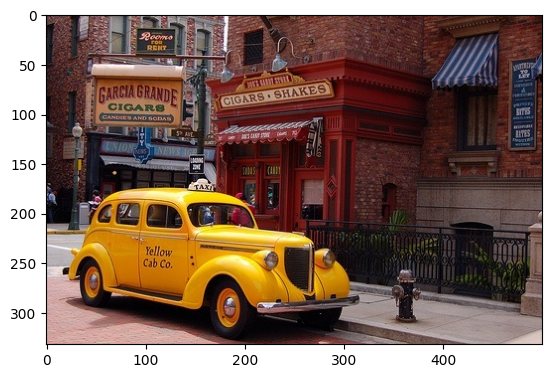

In [12]:
import cv2

train_data_dir = "cGAN\datasets\ImageNet_UrbanSound8K"
img_dir = 'trainA'
stft_dir = 'trainB_stft'
mel_dir = 'trainB_mel'

img_filenames = np.array(os.listdir(os.path.join(train_data_dir, img_dir)))
stft_filenames = np.array(os.listdir(os.path.join(train_data_dir, stft_dir)))
mel_filenames = np.array(os.listdir(os.path.join(train_data_dir, mel_dir)))

i = 186

img_filename = img_filenames[i]
stft_filename = stft_filenames[i]
mel_filename = mel_filenames[i]

print(img_filename, '\n', stft_filename, '\n', mel_filename)
img = cv2.imread(os.path.join(train_data_dir, img_dir, img_filename))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [14]:
# STFT
audio = np.load(os.path.join(train_data_dir, stft_dir, stft_filename))
rec_audio = specgram_to_audio(audio.copy(), spec_type='stft', niter=50)
IPython.display.Audio(data=rec_audio, rate=SAMPLING_RATE)

In [15]:
# Mel-spectrogram
audio = np.load(os.path.join(train_data_dir, mel_dir, mel_filename))
rec_audio = specgram_to_audio(audio.copy(), spec_type='mel', niter=50)
IPython.display.Audio(data=rec_audio, rate=SAMPLING_RATE)

Testing example

dog_bark_0045_A.jpg 
 dog_bark_0045_B.npy 
 dog_bark_0045_B.npy


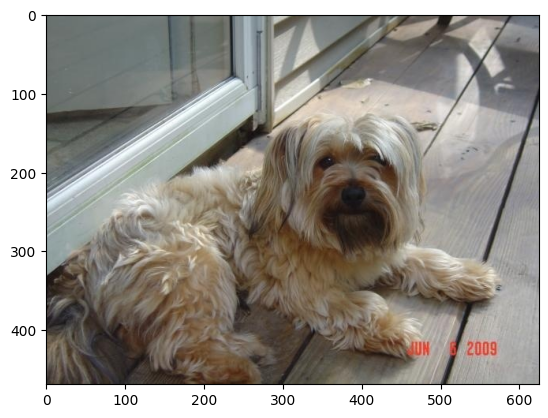

In [16]:
test_data_dir = "cGAN\datasets\ImageNet_UrbanSound8K"
img_dir = 'testA'
stft_dir = 'testB_stft'
mel_dir = 'testB_mel'

img_filenames = np.array(os.listdir(os.path.join(test_data_dir, img_dir)))
stft_filenames = np.array(os.listdir(os.path.join(test_data_dir, stft_dir)))
mel_filenames = np.array(os.listdir(os.path.join(test_data_dir, mel_dir)))

i = 130

img_filename = img_filenames[i]
stft_filename = stft_filenames[i]
mel_filename = mel_filenames[i]

print(img_filename, '\n', stft_filename, '\n', mel_filename)
img = cv2.imread(os.path.join(test_data_dir, img_dir, img_filename))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [17]:
# STFT
audio = np.load(os.path.join(test_data_dir, stft_dir, stft_filename))
rec_audio = specgram_to_audio(audio.copy(), spec_type='stft', niter=50)
IPython.display.Audio(data=rec_audio, rate=SAMPLING_RATE)

In [18]:
# Mel-spectrogram
audio = np.load(os.path.join(test_data_dir, mel_dir, mel_filename))
rec_audio = specgram_to_audio(audio.copy(), spec_type='mel', niter=50)
IPython.display.Audio(data=rec_audio, rate=SAMPLING_RATE)

##### Spectrograms saved in checkpoints directory (were used in training)

In [ ]:
spec_type = 'mel'
checkpoint_dir = "cGAN\checkpoints"
checkpoint_name = f"cGAN_UrbanSound_44kHz_{spec_type}_512_200+100epochs_l10_unet_lr0.001"
spec_dir = f"web/{spec_type}"
img_dir = "web/images"

img_names = np.array([f for f in os.listdir(os.path.join(checkpoint_dir, checkpoint_name, img_dir)) if 'real_A' in f])
spec_names = np.array([f for f in os.listdir(os.path.join(checkpoint_dir, checkpoint_name, spec_dir)) if 'real' in f])

i = 288

img = cv2.imread(os.path.join(checkpoint_dir, checkpoint_name, img_dir, img_names[i]))
print(img_names[i])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [55]:
print(spec_names[i])
audio = np.load(os.path.join(checkpoint_dir, checkpoint_name, spec_dir, spec_names[i]))
real_rec_audio = specgram_to_audio(audio.copy(), spec_type=spec_type, niter=50)
IPython.display.Audio(data=real_rec_audio, rate=SAMPLING_RATE)

epoch289_real_B.npy


##### Spectrograms generated during training

In [56]:
spec_names = np.array([f for f in os.listdir(os.path.join(checkpoint_dir, checkpoint_name, spec_dir)) if 'fake' in f])
print(spec_names[i])
audio = np.load(os.path.join(checkpoint_dir, checkpoint_name, spec_dir, spec_names[i]))
fake_rec_audio = specgram_to_audio(audio.copy(), spec_type=spec_type, niter=50)
IPython.display.Audio(data=fake_rec_audio, rate=SAMPLING_RATE)

epoch289_fake_B.npy


<function matplotlib.pyplot.show(close=None, block=None)>

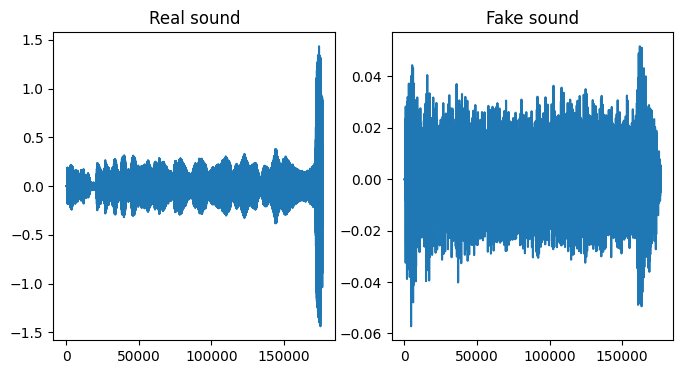

In [57]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.plot(real_rec_audio)
ax1.set_title('Real sound')
ax2.plot(fake_rec_audio)
ax2.set_title('Fake sound')
plt.show

##### Training Log

In [58]:
from datetime import datetime as dt

G_gan_loss = 100
G_l1_loss = 100
D_real_loss = 100
D_fake_loss = 100
best_iter = ''
iter_loss = []
epochs = []
min_G_loss_iter = ''
min_G_loss = 100

def get_time_diff(start, end):
    return str(end - start)

with open(os.path.join(checkpoint_dir, checkpoint_name, 'loss_log.txt'), 'r') as log:
    line = log.readline()

    start_time = line[36:56]
    start_time_dt = dt.strptime(start_time, "%b %d %H:%M:%S %Y")
    print('Start date:', start_time[:-4])
    end_time_dt = dt.fromtimestamp(os.path.getmtime(os.path.join(checkpoint_dir, checkpoint_name, 'latest_net_G.pth')))
    end_time = dt.strftime(end_time_dt, "%b %d %H:%M:%S")
    print('End time: ', end_time)
    time_diff = get_time_diff(start_time_dt, end_time_dt)
    print('Time taken: ', time_diff)

    while line:
        if 'epoch' in line:
            epid1 = line.find('epoch') + 7
            epid2 = line.find(', iters')
            epoch = int(line[epid1:epid2])
            latest_loss = line
            i1 = line.find('G_GAN') + 7
            i2 = line.find('G_L1') + 6
            i3 = line.find('D_real') + 8
            i4 = line.find('D_fake') + 8
            line_losses = [float(line[i1:i1+5]), float(line[i2:i2+5]), float(line[i3:i3+5]), float(line[i4:i4+5])]
            if epoch not in epochs:
                epochs.append(epoch)
                iter_loss.append(line_losses.copy())
            if np.mean([G_gan_loss, G_l1_loss, D_real_loss, D_fake_loss]) > np.mean(line_losses):
                best_iter = line
                G_gan_loss = line_losses[0]
                G_l1_loss = line_losses[1]
                D_real_loss = line_losses[2]
                D_fake_loss = line_losses[3]
            if line_losses[0] < min_G_loss: 
                min_G_loss_iter = line
                min_G_loss = line_losses[0]
        line = log.readline()

print('\nLowest average loss: \n', best_iter)
print('Lowest Generator loss: \n', min_G_loss_iter)
print('Latest epoch loss: \n', latest_loss)

Start date: Apr 26 21:43:17 
End time:  Apr 28 10:31:51
Time taken:  1 day, 12:48:34.210969

Lowest average loss: 
 (epoch: 13, iters: 2104, time: 0.228) D_real: 0.275 D_fake: 0.189 G_GAN: 0.247 G_L1: 0.530 

Lowest Generator loss: 
 (epoch: 93, iters: 2364, time: 0.103) D_real: 0.939 D_fake: 0.749 G_GAN: 0.034 G_L1: 1.154 

Latest epoch loss: 
 (epoch: 300, iters: 4558, time: 0.112) D_real: 0.094 D_fake: 0.040 G_GAN: 0.677 G_L1: 0.961 



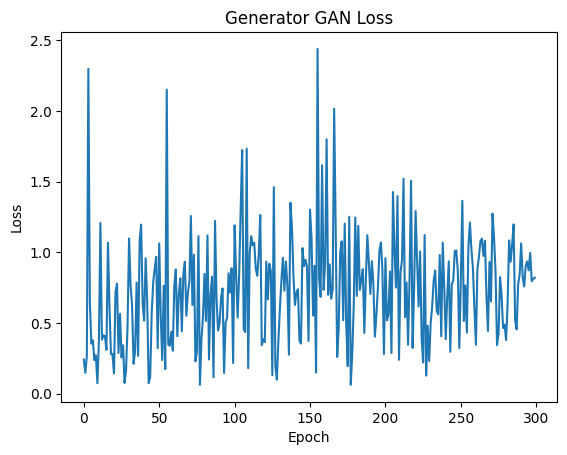

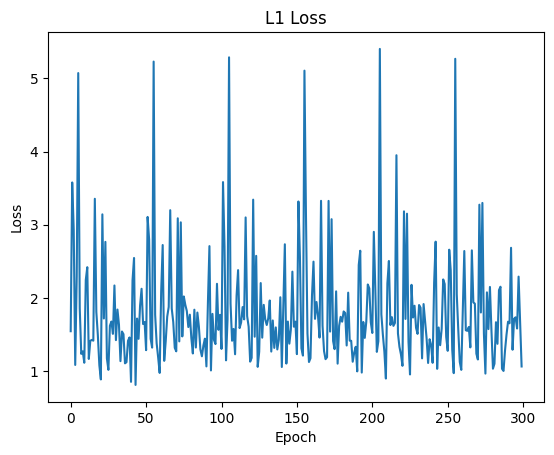

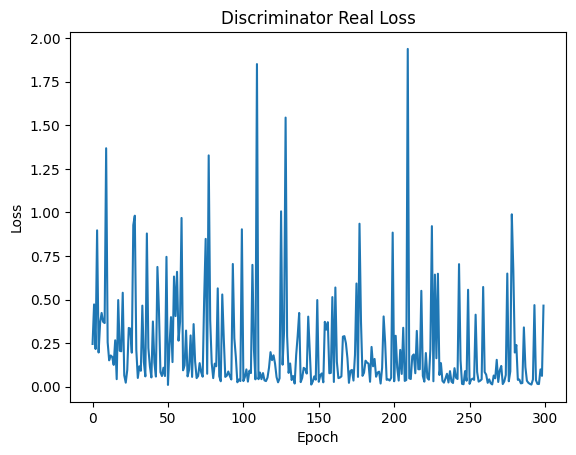

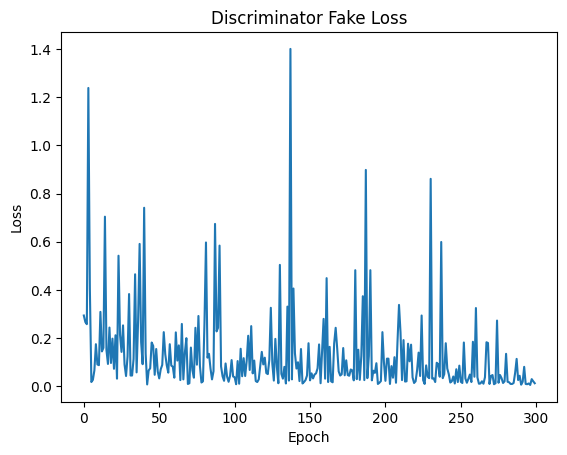

In [59]:
iter_loss = np.array(iter_loss)

plt.plot(iter_loss[:,0])
plt.title('Generator GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(iter_loss[:,1])
plt.title('L1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(iter_loss[:,2])
plt.title('Discriminator Real Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(iter_loss[:,3])
plt.title('Discriminator Fake Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

##### Spectrograms saved in results directory (were used in testing)

gun_shot_0042_A_real_A.png


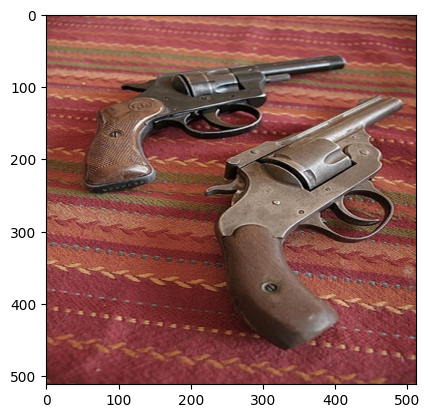

In [75]:
epoch = 'latest'
spec_type = 'mel'
results_dir = "cGAN\\results"
checkpoint_name = f"cGAN_UrbanSound_44kHz_{spec_type}_512_200+100epochs_l10_unet_lr0.001"
spec_dir = f"test_{epoch}/{spec_type}"
img_dir = f"test_{epoch}/images"

img_names = np.array([f for f in os.listdir(os.path.join(results_dir, checkpoint_name, img_dir)) if 'real_A' in f])
spec_names = np.array([f for f in os.listdir(os.path.join(results_dir, checkpoint_name, spec_dir)) if 'real' in f])

i = 720

img = cv2.imread(os.path.join(results_dir, checkpoint_name, img_dir, img_names[i]))
print(img_names[i])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [76]:
print(spec_names[i])
audio = np.load(os.path.join(results_dir, checkpoint_name, spec_dir, spec_names[i]))
real_rec_audio = specgram_to_audio(audio.copy(), spec_type=spec_type, niter=50)
IPython.display.Audio(data=real_rec_audio, rate=SAMPLING_RATE)

gun_shot_0042_A_real_B.npy


##### Spectrograms generated during testing

In [77]:
spec_names = np.array([f for f in os.listdir(os.path.join(results_dir, checkpoint_name, spec_dir)) if 'fake' in f])
print(spec_names[i])
audio = np.load(os.path.join(results_dir, checkpoint_name, spec_dir, spec_names[i]))
fake_rec_audio = specgram_to_audio(audio.copy(), spec_type=spec_type, niter=50)
IPython.display.Audio(data=fake_rec_audio, rate=SAMPLING_RATE)

gun_shot_0042_A_fake_B.npy


<function matplotlib.pyplot.show(close=None, block=None)>

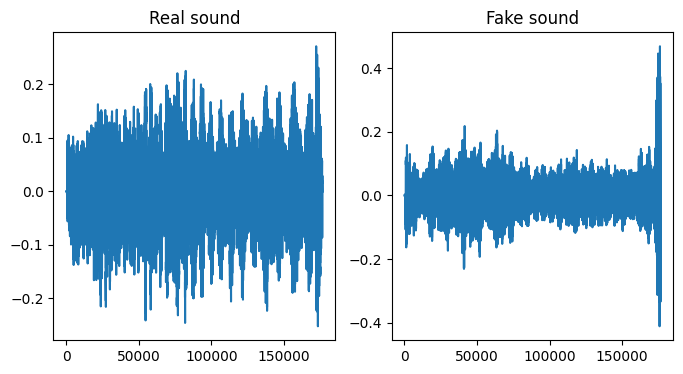

In [67]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.plot(real_rec_audio)
ax1.set_title('Real sound')
ax2.plot(fake_rec_audio)
ax2.set_title('Fake sound')
plt.show

#### Comparing real audio with inverted spectrograms

In [ ]:
audio_dir = "..\\datasets\\UrbanSound8K\\img2audio"
specgrams_dir = "..\\datasets\\UrbanSound8K\\spectrograms"

filenames = np.load(os.path.join(specgrams_dir, 'filenames.npy'))
labels = np.load(os.path.join(specgrams_dir, 'labels.npy'))

mel = np.load(os.path.join(specgrams_dir, 'mel_512.npy'))
stft = np.load(os.path.join(specgrams_dir, 'stft_512.npy'))

i = 2
c = np.unique(labels)[i]

audio_names = np.array([f for f in os.listdir(os.path.join(audio_dir, c))])
spec_idx = np.array([f for f in range(mel.shape[0]) if c in labels[f]])

In [ ]:
j = 2
audio, sr = librosa.load(os.path.join(audio_dir, c, audio_names[j]), sr=SAMPLING_RATE)
spec1 = stft[spec_idx[j]]
spec2 = mel[spec_idx[j]]
audio1 = specgram_to_audio(spec1.copy(), spec_type='stft', niter=50)
audio2 = specgram_to_audio(spec2.copy(), spec_type='mel', niter=50)
print(labels[spec_idx[i]], c)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax1.plot(audio)
ax1.set_title('Real audio')
ax2.plot(audio1)
ax2.set_title('Inverted STFT')
ax3.plot(audio2)
ax3.set_title('Inverted Mel')
plt.show